In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import KFold, cross_val_score

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [4]:
dfn = pd.read_csv('dataset/delirium/noisy2.csv')
dfc = pd.read_csv('dataset/delirium/augmented.csv')
df = pd.concat([dfn, dfc], axis=0)
df.head()

,y,x1,x2,x3,x4,x5
0,0,-0.042449,0.347235,0.208634,-0.521956,0.865522
1,0,-2.051863,0.227998,-0.879599,-0.805739,0.590122
2,0,-1.457464,-0.496188,-0.204515,-1.378020,-0.383293
3,0,-1.068735,-0.567190,-0.527095,-0.401944,-0.370642
4,0,-1.084182,0.550284,0.914777,1.629266,-0.945712


In [5]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
from tqdm import tqdm

In [6]:
X = df.drop(['y'], axis=1)
y = df['y']

In [7]:
# XGBoost Classifier
model = XGBClassifier()

# Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_log_loss', n_jobs=-1)
grid_search.fit(X, y)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best neglog:", best_score)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Best neglog: -0.12481892189659269


In [8]:
model = grid_search.best_estimator_

In [9]:
predictions = model.predict(X)
pred_proba = model.predict_proba(X)[:, 1]

In [10]:
def scale(df):
    scaler = StandardScaler().fit(df.drop('y', axis=1))
    scaled_data = scaler.transform(df.drop('y', axis=1))
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns[1:])
    scaled_df.insert(0, 'y', df['y'])
    return scaled_df

In [11]:
dft = pd.read_csv('dataset/delirium/top5.csv')
dft = dft.drop(dft.columns[-1], axis=1)
dft.head()

,CAM-ICU positive,CXC13L,EOTL,HGFL,VEGFAL,CD3_neg_CD19_pos_CD27_pos_IgD_pos_IgM_pos
0,No Delirium,159,65,1291,731,12.0
1,No Delirium,25,42,300,347,9.8
2,No Delirium,113,23,746,256,6.6
3,No Delirium,33,34,760,579,4.2
4,No Delirium,215,57,1518,2376,2.5


In [12]:
dft.columns = ['y'] + ['x' + str(i) for i in range(1, len(dft.columns))]
dft['y'] = dft['y'].map({'No Delirium': 0, 'Delirium': 1, 'No_Delirium': 0})
dft.head()

,y,x1,x2,x3,x4,x5
0,0,159,65,1291,731,12.0
1,0,25,42,300,347,9.8
2,0,113,23,746,256,6.6
3,0,33,34,760,579,4.2
4,0,215,57,1518,2376,2.5


In [13]:
dft = scale(dft)
dft.head()

,y,x1,x2,x3,x4,x5
0,0,-0.681270,0.773231,0.167699,-0.304673,0.813831
1,0,-1.354814,-0.195844,-0.799771,-0.750116,0.486314
2,0,-0.912487,-0.996383,-0.364361,-0.855676,0.009925
3,0,-1.314603,-0.532913,-0.350693,-0.480994,-0.347367
4,0,-0.399789,0.436162,0.389310,1.603536,-0.600449


In [14]:
Xt = dft.drop('y', axis=1).values
yt = dft['y'].values

In [15]:
yhat = model.predict(Xt)
yhat_proba = model.predict_proba(Xt)[:, 1]

In [16]:
accuracy = accuracy_score(yt, yhat)
auc = roc_auc_score(yt, yhat)
print("Accuracy:", accuracy)
print("AUC:", auc)

Accuracy: 0.9259259259259259
AUC: 0.9102941176470588


In [17]:
yhat

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

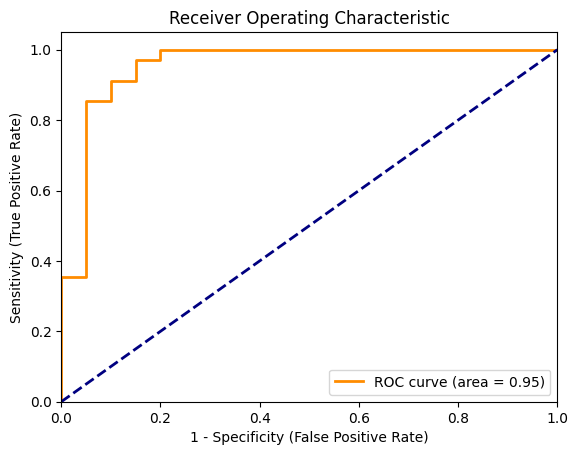

In [18]:
from sklearn.metrics import roc_curve, auc

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(yt, yhat_proba)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [34]:
# Find optimal threshold
j_scores = tpr - fpr
j_ordered = sorted(zip(j_scores, thresholds))
best_threshold = j_ordered[-1][1]

# Calculate sensitivity and specificity
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
sensitivity = tpr[optimal_idx]
specificity = 1 - fpr[optimal_idx]

In [35]:
sensitivity

np.float64(0.9705882352941176)

In [36]:
specificity

np.float64(0.85)

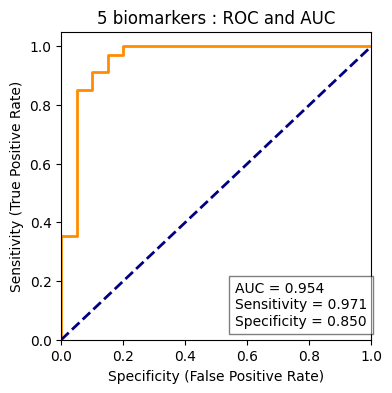

In [39]:
# Plotting
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('5 biomarkers : ROC and AUC')
#plt.legend(loc="lower right")

# Add custom text box
plt.text(0.56, 0.05, 'AUC = %0.3f\nSensitivity = %0.3f\nSpecificity = %0.3f' % (roc_auc, sensitivity, specificity),
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()
